# Stream-based sampling

## Imports

In [1]:
import numpy as np

In [2]:
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner

## Create image

In [3]:
# creating the image
im_width = 500
im_height = 500
im = np.zeros((im_height, im_width))
im[100:im_width - 1 - 100, 100:im_height - 1 - 100] = 1

## Create Stream data

In [4]:
# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

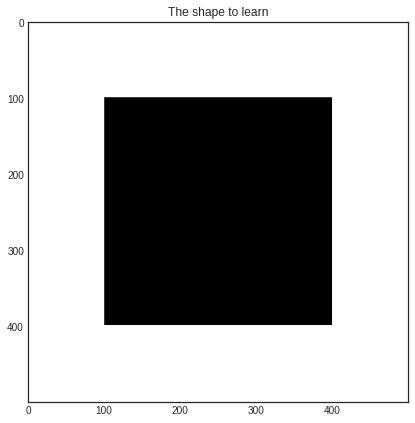

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(im)
    plt.title('The shape to learn')
    plt.show()

## First loop query

In [30]:
# assembling initial training set
n_initial = 19
initial_idx = np.random.choice(range(len(X_full)), size=n_initial, replace=False)
X_train, y_train = X_full[initial_idx], y_full[initial_idx]

# initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X_full, y_full)

print('Initial prediction accuracy: %f' % unqueried_score)

Initial prediction accuracy: 0.842252


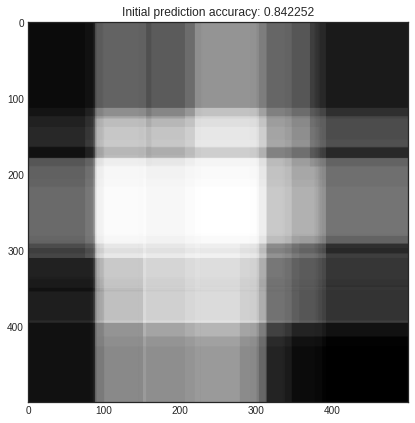

In [31]:
# visualizing initial prediciton
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict_proba(X_full)[:, 0]
    plt.imshow(prediction.reshape(im_width, im_height))
    plt.title('Initial prediction accuracy: %f' % unqueried_score)
    plt.show()

## Stream-based sampling

In [8]:
from modAL.uncertainty import classifier_uncertainty

performance_history = [unqueried_score]
X_passed_idx = []
X_passed_idx_idx = []
# learning until the accuracy reaches a given threshold
while learner.score(X_full, y_full) < 0.90:
    stream_idx = np.random.choice(range(len(X_full)))
    if classifier_uncertainty(learner, X_full[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(X_full[stream_idx].reshape(1, -1), y_full[stream_idx].reshape(-1, ))
        new_score = learner.score(X_full, y_full)
        performance_history.append(new_score)
        print('Pixel no. %d queried, new accuracy: %f' % (stream_idx, new_score))
        #print('Pixel no. %d queried: Position: [%d] [%d]' %(stream_idx,X_full[stream_idx][0],X_full[stream_idx]))
        X_passed_idx_idx.append(stream_idx)
        X_passed_idx.append([X_full[stream_idx][0],X_full[stream_idx][1]])



Pixel no. 111182 queried, new accuracy: 0.656736
Pixel no. 32050 queried, new accuracy: 0.762964
Pixel no. 172663 queried, new accuracy: 0.771988
Pixel no. 168299 queried, new accuracy: 0.793988
Pixel no. 88986 queried, new accuracy: 0.811308
Pixel no. 145055 queried, new accuracy: 0.786820
Pixel no. 120651 queried, new accuracy: 0.824424
Pixel no. 66721 queried, new accuracy: 0.854796
Pixel no. 69380 queried, new accuracy: 0.821936
Pixel no. 176389 queried, new accuracy: 0.790472
Pixel no. 205680 queried, new accuracy: 0.792148
Pixel no. 193344 queried, new accuracy: 0.810400
Pixel no. 175944 queried, new accuracy: 0.836512
Pixel no. 186597 queried, new accuracy: 0.833700
Pixel no. 160598 queried, new accuracy: 0.829824
Pixel no. 75999 queried, new accuracy: 0.839552
Pixel no. 197108 queried, new accuracy: 0.834108
Pixel no. 31427 queried, new accuracy: 0.856572
Pixel no. 8873 queried, new accuracy: 0.966104


In [9]:
X_passed = [np.array(X_passed_idx_idx), np.array(X_passed_idx)]

## Results

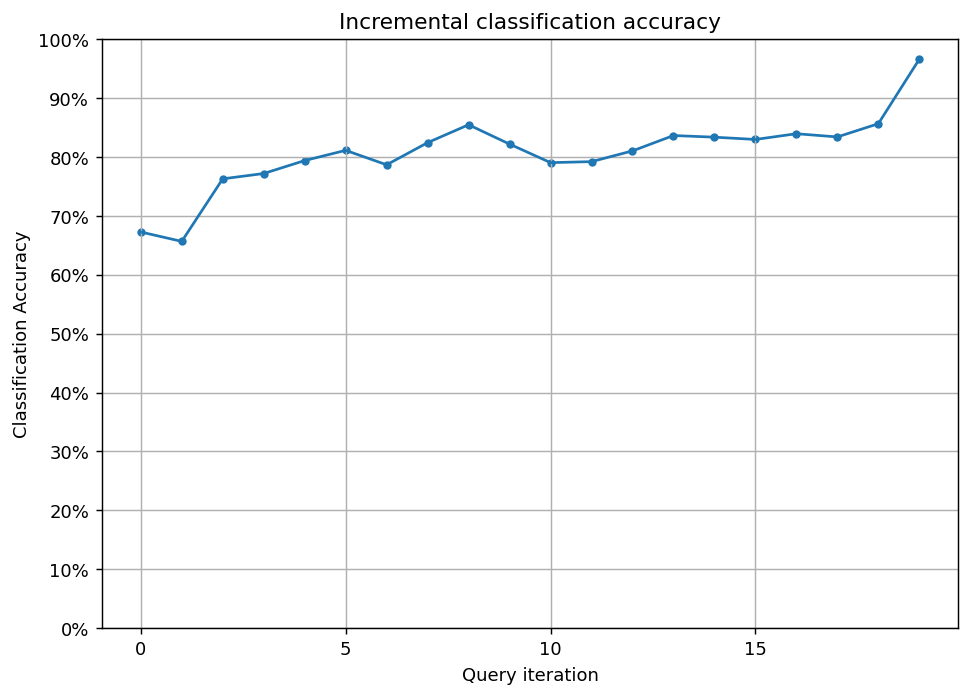

In [10]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Last query result visualization

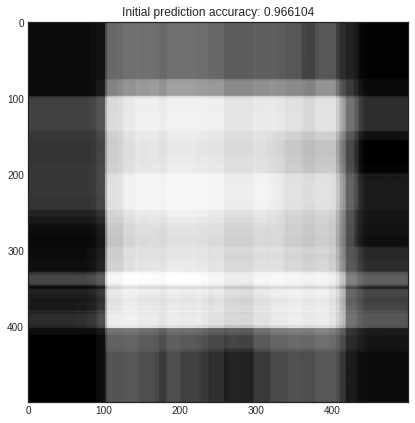

In [16]:
# visualizing initial prediciton
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict_proba(X_full)[:, 0]
    plt.imshow(prediction.reshape(im_width, im_height))
    plt.title('Initial prediction accuracy: %f' % performance_history[len(X_passed[0])])
    plt.show()

## Expected Error

In [32]:
import modAL.expected_error

X_expected = modAL.expected_error.expected_error_reduction(learner, X_full, n_instances=len(X_passed[0]))

In [33]:
print ("X expected")
print (X_expected)
print ("\n\n")
print ("X passed")
print (X_passed)

X expected
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 18, 16,
       17, 15]), array([[136, 306],
       [239, 393],
       [290, 205],
       [265, 154],
       [474, 176],
       [309, 259],
       [280, 254],
       [ 58,  95],
       [ 51, 315],
       [382, 460],
       [ 37, 174],
       [172,  72],
       [461, 398],
       [112, 279],
       [471, 303],
       [ 62, 392],
       [117, 182],
       [315, 433],
       [284, 238]]))



X passed
[array([111182,  32050, 172663, 168299,  88986, 145055, 120651,  66721,
        69380, 176389, 205680, 193344, 175944, 186597, 160598,  75999,
       197108,  31427,   8873]), array([[182, 222],
       [ 50,  64],
       [163, 345],
       [299, 336],
       [486, 177],
       [ 55, 290],
       [151, 241],
       [221, 133],
       [380, 138],
       [389, 352],
       [180, 411],
       [344, 386],
       [444, 351],
       [ 97, 373],
       [ 98, 321],
       [499, 151],
       [108, 394],
       [427,  62],
   